In [241]:
import os;
import json;
import builtins
import pandas as pd;

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge'
testcase = 'pgm_vs_flat/index_fb_1'
test_dir = os.path.join(dir, testcase)
results_dir = os.path.join(test_dir, 'outputs', 'results')
csv_dir = os.path.join(test_dir, 'csv')
os.makedirs(csv_dir, exist_ok=True)

runs = [os.path.join(results_dir, run) for run in os.listdir(results_dir)]
print(runs)

['/home/chesetti/Repos/learned_merge_cleanup/sponge/pgm_vs_flat/index_fb_1/outputs/results/run']


In [ ]:
# Walk all the json files and put them in a dataframe

test_results = []
for run in runs:
    for test_result_file in os.listdir(run):
        json_file = builtins.open(os.path.join(run, test_result_file))
        test_result = json.load(json_file)
        test_result['run'] = run
        test_results.append(test_result)
        json_file.close()
test_dataframe = pd.json_normalize(test_results)
print(test_dataframe.columns)

        

Index(['command', 'run', 'result.checksum', 'result.duration_ns',
       'result.duration_sec', 'result.inner_disk_fetch',
       'result.inner_disk_fetch_size', 'result.inner_total_bytes_fetched',
       'result.outer_disk_fetch', 'result.outer_disk_fetch_size',
       'result.outer_total_bytes_fetched', 'spec.algo', 'spec.algo_name',
       'spec.check_checksum', 'spec.common_key',
       'spec.index.leaf_size_in_pages', 'spec.index.search', 'spec.index.type',
       'spec.inner_table', 'spec.key_size', 'spec.key_type',
       'spec.load_sstable_in_mem', 'spec.name', 'spec.num_threads',
       'spec.outer_table', 'spec.result_path', 'spec.value_size',
       'spec.write_result_to_disk'],
      dtype='object')


# Reports

### Overall Duration

Index(['btree2048', 'flatpgm2048', 'flatpgm256', 'hj', 'inljBtree2048',
       'inljBtree256', 'inljPgm256', 'sj'],
      dtype='object', name='spec.algo_name')
Index([1, 5, 10, 50, 100, 500, 1000], dtype='int64', name='spec.common_key')
|   spec.common_key |   btree2048 |   flatpgm2048 |   flatpgm256 |          hj |   inljBtree2048 |   inljBtree256 |   inljPgm256 |          sj |
|------------------:|------------:|--------------:|-------------:|------------:|----------------:|---------------:|-------------:|------------:|
|                 1 | 4.63594e+10 |   2.84099e+10 |  2.55317e+10 | 7.90496e+10 |     5.13647e+10 |    5.24128e+10 |  3.94349e+10 | 1.63171e+10 |
|                 5 | 1.07371e+10 |   6.79721e+09 |  6.73741e+09 | 4.78034e+10 |     1.06209e+10 |    1.13226e+10 |  8.72369e+09 | 6.37982e+09 |
|                10 | 5.71406e+09 |   4.31711e+09 |  4.36369e+09 | 4.57126e+10 |     5.84211e+09 |    5.92203e+09 |  4.97993e+09 | 4.4793e+09  |
|                50 | 1.5631e+09  |  

'\nfor column in throughput.columns:\n    throughput[column] = (200_000_000/throughput.index) * (1000_000_000.0 / throughput[column])\n    throughput[column +"_sj-rel"] = (throughput[column] - throughput["sj"] / throughput["sj"]) * 100.0\nprint(throughput)\noverall_duration[["btree2048", "btree1024", "btree256", "sj"]].plot() \noverall_duration[["pgm128", "pgm512", "pgm1024", "sj"]].plot() \n'

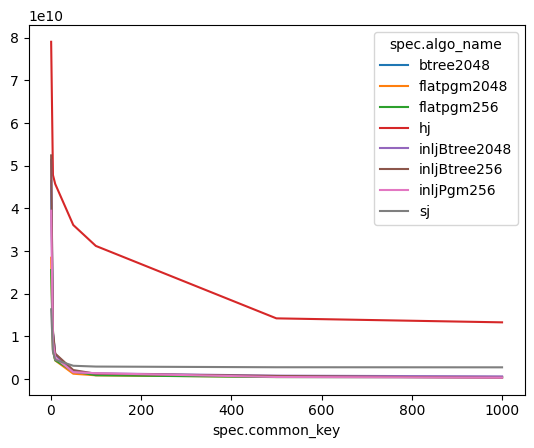

In [ ]:
overall_duration = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.duration_ns', aggfunc='median')
overall_duration.to_csv(os.path.join(csv_dir, 'duration_sec.csv'))
print(overall_duration.columns)
print(overall_duration.index)
throughput = overall_duration
print(throughput.to_markdown())
throughput.plot()
'''
for column in throughput.columns:
    throughput[column] = (200_000_000/throughput.index) * (1000_000_000.0 / throughput[column])
    throughput[column +"_sj-rel"] = (throughput[column] - throughput["sj"] / throughput["sj"]) * 100.0
print(throughput)
overall_duration[["btree2048", "btree1024", "btree256", "sj"]].plot() 
overall_duration[["pgm128", "pgm512", "pgm1024", "sj"]].plot() 
'''

In [ ]:
inner_index_fetch = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_disk_fetch', aggfunc='median')
inner_index_total_fetch = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_total_bytes_fetched', aggfunc='median')
inner_index_fetch_size = test_dataframe.pivot_table(index='spec.common_key', columns='spec.algo_name', values='result.inner_disk_fetch_size', aggfunc='median')
print(inner_index_total_fetch)


spec.algo_name    btree2048  flatpgm2048  flatpgm256          hj  \
spec.common_key                                                    
1                3199999984   3199999984  3199999984  3199999984   
5                3199999984   3199996528  3199701584  3199999984   
10               3199999984   3199978400  3198583488  3199999984   
50               3199999984   3199241504  3151788720  3199999984   
100              3199999984   3196612896  3008926736  3199999984   
500              3145375728   3067582128  1827393680  3199999984   
1000             2790653952   2733751040  1182334976  3199999984   

spec.algo_name   inljBtree2048  inljBtree256  inljPgm256          sj  
spec.common_key                                                       
1                   3199999984    3199999984  8586481472  3199999984  
5                   3199999984    3199999984  8290457984  3199999984  
10                  3199999984    3199999984  7966168496  3199999984  
50                  3199999984  

In [ ]:
result_checksum = (test_dataframe[['spec.common_key', 'spec.algo_name', 'result.checksum']].sort_values(by=['spec.common_key', 'spec.algo_name'])) #.loc[test_dataframe['spec.common_key']=='10'])
for common_key in sorted(test_dataframe['spec.common_key'].unique()):
    checksums = result_checksum.loc[result_checksum['spec.common_key'] == common_key]
    unique_checksums = checksums['result.checksum'].unique()
    if (len(unique_checksums) == 1):
        print(f"common_key: {common_key} checksum: {unique_checksums} OK")
    else:
        print(f"common_key: {common_key} checksums don't match")
print(result_checksum.loc[result_checksum['spec.common_key'] == 100])
print(result_checksum.loc[result_checksum['spec.common_key'] == 100]['result.checksum'].unique())

common_key: 1 checksum: ['197D7E88032185A864E14627A72FA7A5'] OK
common_key: 5 checksum: ['2EBD8A17D005B04E8C09FC88916E5302'] OK
common_key: 10 checksum: ['48A27649D5132ED7803507616E711726'] OK
common_key: 50 checksum: ['51081A5D73E93BA4918BF9573E112CEB'] OK
common_key: 100 checksum: ['044514FD169FDEE3F58AF5B536F568DC'] OK
common_key: 500 checksum: ['2E38EB1C5DCBCA7ACCCA945109B8B54C'] OK
common_key: 1000 checksum: ['552C6EA07200327213F89557642EBCC6'] OK
     spec.common_key spec.algo_name                   result.checksum
43               100      btree2048  044514FD169FDEE3F58AF5B536F568DC
99               100      btree2048  044514FD169FDEE3F58AF5B536F568DC
84               100    flatpgm2048  044514FD169FDEE3F58AF5B536F568DC
101              100    flatpgm2048  044514FD169FDEE3F58AF5B536F568DC
5                100     flatpgm256  044514FD169FDEE3F58AF5B536F568DC
66               100     flatpgm256  044514FD169FDEE3F58AF5B536F568DC
4                100             hj  044514FD169FDEE3